In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from pandas.tseries.offsets import BDay

import backtest_tools.portfolio_tools as backtest_tools
import backtest_tools.data_cleaning_tools as cleaning
import pickle

In [110]:
path = r'C:\Users\marcu\Documents\Quant\Programming\Data\russell_300_returns.pickle'

In [111]:
with open(path, 'rb') as reader:
    returns = pickle.load(reader)

In [354]:
# For some reason pandas rolling objects don't have a prod method, but you can apply NumPy prod to them. 
# Also, you need to add 1 to your DataFrame and later subtract it, so the most straightforward one-liner approach would be
# rolling_cum_rets = (1+returns).rolling(window=20).apply(np.prod) - 1

# However, this is very computationally inefficient due to the complexity of multiplication vs. addition (the same reason max log liklihood is used vs. simple liklihood).
# Therefore we will use log returns, compute their sum over the rolling window for a final cum return value, then convert log returns back to raw returns via e

rolling_cum_rets = np.exp(np.log(1+returns).rolling(window=int(252/2)).sum() - 1)

# Standardize Rolling Cumulative Returns: Z-Score
# rolling_cum_rets = (rolling_cum_rets - rolling_cum_rets.mean()) / rolling_cum_rets.std()

In [4]:
rolling_cum_rets = returns.rolling(window=int(20)).std()*252**.5

In [311]:
# # Create a monthly date range of exclusively business days
# date_range = pd.bdate_range(start='2021-01-01', end=rolling_cum_rets.index[-1], )
# n = int(.1*rolling_cum_rets.index.size)

# long_weight = .5
# short_weight = .5
# weights = {}

# for i in rolling_cum_rets.groupby(pd.Grouper(freq='M')).last():

#     tmp_rolling_cum_rets = rolling_cum_rets.loc[i].dropna()

#     if len(tmp_rolling_cum_rets) > 0:
#         n = int(tmp_rolling_cum_rets.index.size*.1)

#         long_tickers = tmp_rolling_cum_rets.nlargest(n).index
#         short_tickers = tmp_rolling_cum_rets.nsmallest(n).index

#         # Equally weighted market neutral portfolio of longs and shorts - abs(weights) = 1
#         # Set long weights
#         # tmp_long_weights = pd.Series(np.ones(n)/(n*2), index=long_tickers)
#         # # Set short weights
#         # tmp_short_weights = pd.Series(np.ones(n)*-1/(n*2), index=short_tickers)
#         # Set non-invested weights to zero
#         tmp_rest_weights = pd.Series(np.zeros(returns.columns.size - 2*n), index= returns.drop(columns=long_tickers.append(short_tickers), inplace=False).columns)

#         tmp_long_weights = pd.Series(np.ones(n), index=long_tickers)
#         # Set short weights
#         tmp_short_weights = pd.Series(np.ones(n)*-1, index=short_tickers)
        
#         weights[i] = pd.concat([tmp_long_weights, tmp_short_weights, tmp_rest_weights])

# weights[rolling_cum_rets.index[-1]] = pd.Series()

# weights = pd.DataFrame(weights).T
# weights = pd.DataFrame(weights, index=returns.index).ffill()

# # universe = weights.columns.intersection(returns.columns)
# # returns = returns[universe]
# # weights = weights[universe]

Old Class

In [ ]:

# class factor_strategy():

#     def __init__(self, returns: pd.DataFrame, rolling_window=20, rebal_freq = 'M', factor_type='long', p=0.50, filter_type='high_vol', daily_ret_filter_threshold=10):
         
#         self.rolling_window = rolling_window

#         # Use either pandas shorthand for rebal_freq or numeric daily value using BDay
#         if type(rebal_freq) is str:
#             self.rebal_freq = rebal_freq
#         else:
#             self.rebal_freq = BDay(int(rebal_freq))
        
#         self.factor_type = factor_type
#         self.p = p
#         self.filter_type = filter_type
#         self.daily_ret_filter_threshold = daily_ret_filter_threshold

#         # Clean returns (drop outlier daily returns + filter for volatilty)
#         self.returns = self.clean_returns(returns=returns, p=self.p, filter_type=self.filter_type, daily_ret_threshold=self.daily_ret_filter_threshold)
        
#         # Compute factor
#         self.full_factor_history = self.get_factor()
        
#         # Get factor values at a rebal_freq period frequency
#         self.factor = self.full_factor_history.groupby(pd.Grouper(freq=self.rebal_freq)).last()

#         # Get portfolio weights and factor returns
#         self.portfolio, self.factor_returns = self.get_weights_and_returns(self.factor, self.returns, self.factor_type)

#         # Execute performance analysis
#         self.performance_summary = backtest_tools.performance_summary(self.factor_returns)

#         # Get cumulative returns
#         self.cumulative_returns = backtest_tools.cumulative_returns(self.factor_returns)

#         # Plot cumulative returns for rapid ideation
#         self.cumulative_returns.plot(figsize=(12, 6))
#         plt.show()

#         return
    
#     def get_factor(self):
#         """ Custom Factor
#         """
#         # rolling cum rets factor
#         factor_data = np.exp(np.log(1+self.returns).rolling(window=int(252)).sum() - 1)
#         factor_data = (factor_data - factor_data.mean()) / factor_data.std()
        
#         return factor_data

#         # rolling_vol factor
#         # factor_data = self.returns.rolling(window=self.rolling_window).std()*252**.5
        
#         return factor_data

#     def clean_returns(self, returns, p=0.50, filter_type='high_vol', daily_ret_threshold=10):
#         returns = cleaning.drop_outlier_returns(returns, daily_ret_threshold=daily_ret_threshold)
#         returns = cleaning.volatility_filter(returns, p=p, filter_type=filter_type)

#         return returns

#     # Function to assign portfolio weights to ranked tickers
#     def get_weights(self, factor, factor_type='long'):

#         n = int(len(factor.dropna())*.1)

#         if n>0:

#             try:

#                 # Get quintile largers tickers' cum rets
#                 nlargest = factor.nlargest(n)
#                 nsmallest = factor.nsmallest(n)

#                 # print('='*50)
#                 # print(nlargest.index)
#                 # print(factor.nlargest(n))
#                 # print(nsmallest.index)
#                 # print(factor.nsmallest(n))
#                 # print('='*50)

#                 long_weight = 1/(n*2)
#                 short_weight = 1/(n*2)*-1
#                 # long_weight = 1/(n)
#                 # short_weight = 1/(n)*-1

#                 if(factor_type=='long'):
#                     nlargest[nlargest.index] = long_weight  
#                     nsmallest[nsmallest.index] = short_weight
#                 elif(factor_type=='short'):
#                     nlargest[nlargest.index] = short_weight 
#                     nsmallest[nsmallest.index] = long_weight
#                 else:
#                     raise ValueError('Respecify factor_type')

#                 weights = pd.concat([nlargest, nsmallest])

#                 return weights
            
#             except: 
#                 print(n, factor.nlargest(n))
                
#         return factor*0

#     def get_weights_and_returns(self, factor: pd.DataFrame, returns: pd.DataFrame, factor_type='long'):

#         wts = {}

#         for i, tmp_factor in factor.T.items():
#             wts[i] = self.get_weights(tmp_factor, factor_type=factor_type)
        
#         # Tranpose pd.DataFrame to ensure indices are dates and columns are tickers
#         wts = pd.DataFrame(wts).T

#         # Fill NaNs to 0 so we can ffill the weights' pd.DataFrame
#         wts = wts.fillna(0)
#         # Create a temporary pd.DataFrame with returns.index which will enable us to ffill weights as well
#         tmp_wts = pd.DataFrame(index=returns.index)
#         wts = pd.concat([wts, tmp_wts], axis=1).ffill()

#         # Check that weights add to 0 to ensure market netural strategy
#         wts_sum = wts.sum().sum().round(4)
#         print(f"Weights SUM: {'Market Neutral' if wts_sum == 0 else 'Not Market Netrual'} = {wts_sum}")

#         # Plot example of stock weights over time for given factor
#         wts.iloc[:, 1:20].plot(title="Sample Weights Over Time", figsize=(12, 6))
#         plt.show()

#         # Compute returns
#         factor_returns = (wts*returns).sum(1)

#         return wts, factor_returns

New Class

In [134]:
class factor_strategy():

    def __init__(self, returns: pd.DataFrame, factor_function, rolling_window=20, rebal_freq = 'M', factor_type='long', p=0.50, filter_type='high_vol', daily_ret_filter_threshold=10):
         
        self.factor_function = factor_function
        
        self.rolling_window = rolling_window

        # Use either pandas shorthand for rebal_freq or numeric daily value using BDay
        if type(rebal_freq) is str:
            self.rebal_freq = rebal_freq
        else:
            self.rebal_freq = BDay(int(rebal_freq))
            raise ValueError('Numeric rebalancing frequencies are currently unsupported.')
        
        self.factor_type = factor_type
        self.p = p
        self.filter_type = filter_type
        self.daily_ret_filter_threshold = daily_ret_filter_threshold

        # Clean returns (drop outlier daily returns + filter for volatilty)
        self.returns = self.clean_returns(returns=returns, p=self.p, filter_type=self.filter_type, daily_ret_threshold=self.daily_ret_filter_threshold)
        
        # Compute factor
        self.full_factor_history = self.get_factor(returns=self.returns, factor_function=self.factor_function)
        
        # Get factor values at a rebal_freq period frequency
        self.factor = self.full_factor_history.groupby(pd.Grouper(freq=self.rebal_freq)).last()

        # Get portfolio weights and factor returns
        self.portfolio_weights, self.factor_returns = self.get_weights_and_returns(factor=self.factor, returns=self.returns, factor_type=self.factor_type)

        # Execute performance analysis
        self.performance_summary = backtest_tools.performance_summary(self.factor_returns)

        # Get cumulative returns
        self.cumulative_returns = backtest_tools.cumulative_returns(self.factor_returns)

        # Plot cumulative returns for rapid ideation
        self.cumulative_returns.plot(figsize=(12, 6))
        plt.show()

        return
    
    def get_factor(self, returns, factor_function):
        """ Custom Factor
        """
        # rolling cum rets factor
        #factor_data = np.exp(np.log(1+self.returns).rolling(window=int(252/2)).sum() - 1)

        # rolling_vol factor
        #factor_data = returns.rolling(window=self.rolling_window).std()*252**.5
        
        return factor_function(returns)

    def clean_returns(self, returns, p=0.50, filter_type='high_vol', daily_ret_threshold=10):
        returns = cleaning.drop_outlier_returns(returns, daily_ret_threshold=daily_ret_threshold)
        returns = cleaning.volatility_filter(returns, p=p, filter_type=filter_type)

        return returns

    # Function to assign portfolio weights to ranked tickers
    def get_weights(self, factor, factor_type='long'):

        n = int(len(factor.dropna())*.1)

        if n>0:

            try:

                # Get quintile largers tickers' cum rets
                nlargest = factor.nlargest(n)
                nsmallest = factor.nsmallest(n)

                # print('='*50)
                # print(nlargest.index)
                # print(factor.nlargest(n))
                # print(nsmallest.index)
                # print(factor.nsmallest(n))
                # print('='*50)

                long_weight = 1/(n*2)
                short_weight = 1/(n*2)*-1
                # long_weight = 1/(n)
                # short_weight = 1/(n)*-1

                if(factor_type=='long'):
                    nlargest[nlargest.index] = long_weight  
                    nsmallest[nsmallest.index] = short_weight
                elif(factor_type=='short'):
                    nlargest[nlargest.index] = short_weight 
                    nsmallest[nsmallest.index] = long_weight
                else:
                    raise ValueError('Respecify factor_type')

                weights = pd.concat([nlargest, nsmallest])

                return weights
            
            except: 
                print(n, factor.nlargest(n))
                
        return factor*0

    def get_weights_and_returns(self, factor: pd.DataFrame, returns: pd.DataFrame, factor_type='long'):

        wts = {}

        for i, tmp_factor in factor.T.items():
            wts[i] = self.get_weights(tmp_factor, factor_type=factor_type)
        
        # Tranpose pd.DataFrame to ensure indices are dates and columns are tickers
        wts = pd.DataFrame(wts).T

        # Fill NaNs to 0 so we can ffill the weights' pd.DataFrame
        wts = wts.fillna(0)
        # Create a temporary pd.DataFrame with returns.index which will enable us to ffill weights as well
        tmp_wts = pd.DataFrame(index=returns.index)
        wts = pd.concat([wts, tmp_wts], axis=1).ffill()
        wts = wts.loc[returns.index, :]

        # Check that weights add to 0 to ensure market netural strategy
        wts_sum = wts.sum().sum().round(4)
        print(f"Weights SUM: {'Market Neutral' if wts_sum == 0 else 'Not Market Netrual'} = {wts_sum}")

        # Plot example of stock weights over time for given factor
        wts.iloc[:, 1:20].plot(title="Sample Weights Over Time", figsize=(12, 6))
        plt.show()

        # Compute returns
        factor_returns = (wts*returns).sum(1)

        return wts, factor_returns

Example Factors / Features

In [126]:
def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=252).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    return vol_mom_factor

def momentum(returns: pd.DataFrame):
    rolling_cum_rets = np.exp(np.log(1+returns).rolling(window=int(252)).sum() - 1)
    rolling_cum_rets = (rolling_cum_rets - rolling_cum_rets.mean()) / rolling_cum_rets.std()
    return rolling_cum_rets

Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


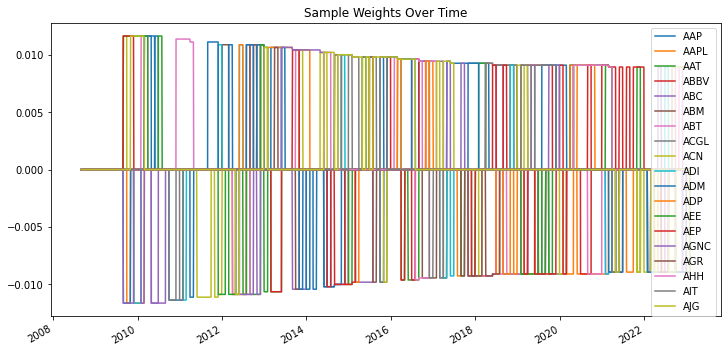

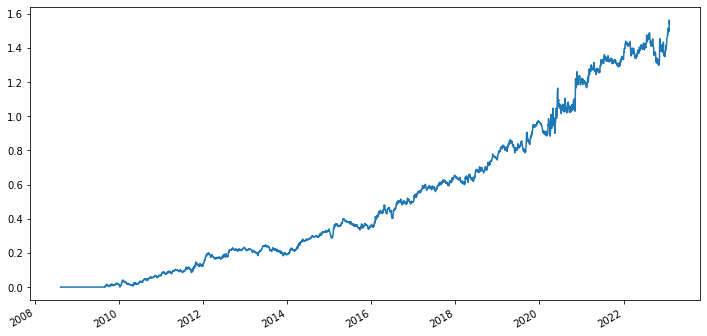

Sharpe Ratio                    1.010785
Drift Adjusted Sharpe Ratio     0.741245
CAGR                            0.066605
Vol                             0.065938
Sortino Ratio                   1.644510
Martin (Ulcer) Ratio            0.002104
Omega Ratio                     0.997035
RR Ratio                        1.217506
Win Rate                        0.509021
Skew                            2.197247
Kurtosis                       36.765116
Max Drawdown                   -0.076609
VaR - Laplace                  -0.016399
CVaR - Laplace                 -0.019930
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


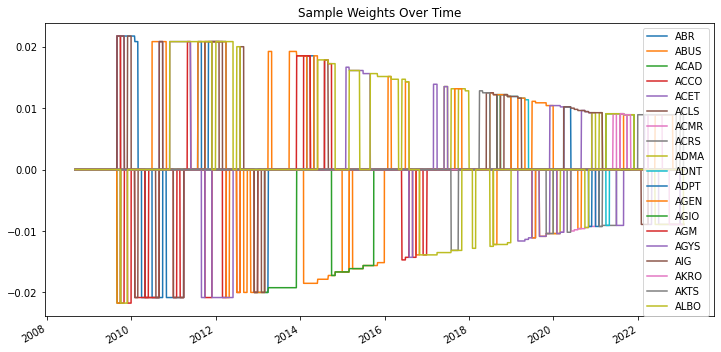

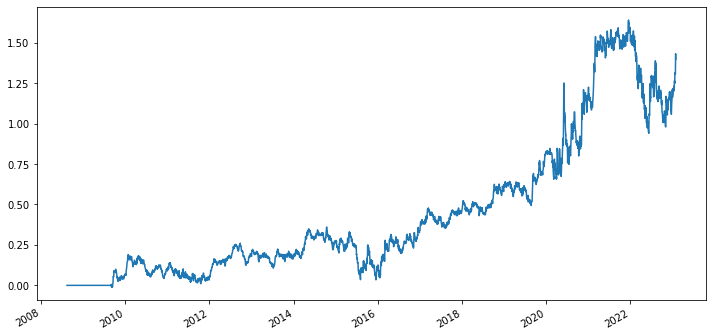

Sharpe Ratio                    0.467006
Drift Adjusted Sharpe Ratio     0.137286
CAGR                            0.062229
Vol                             0.154717
Sortino Ratio                   0.742510
Martin (Ulcer) Ratio            0.000539
Omega Ratio                     1.005513
RR Ratio                        1.090898
Win Rate                        0.493937
Skew                            1.185322
Kurtosis                       14.444635
Max Drawdown                   -0.265112
VaR - Laplace                  -0.039316
CVaR - Laplace                 -0.049213
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


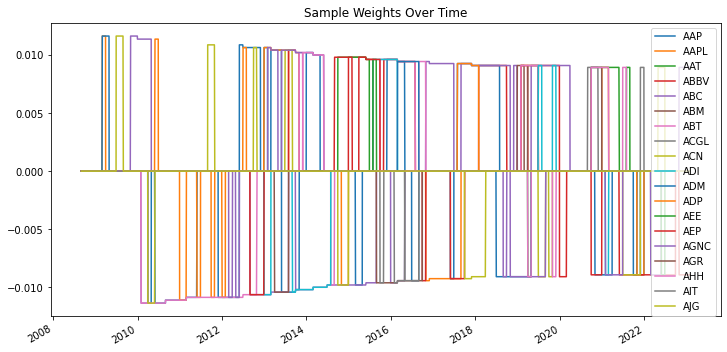

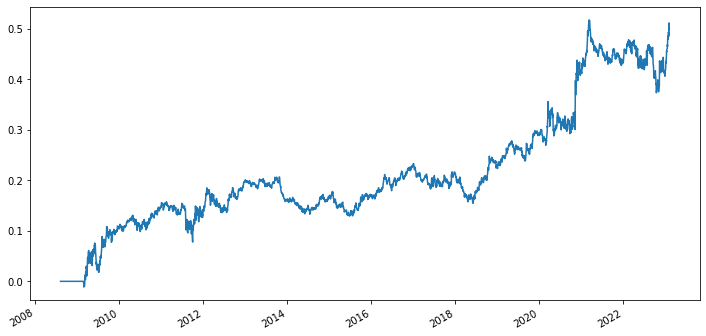

Sharpe Ratio                    0.528328
Drift Adjusted Sharpe Ratio     0.254543
CAGR                            0.028313
Vol                             0.055778
Sortino Ratio                   0.796737
Martin (Ulcer) Ratio            0.000605
Omega Ratio                     0.877036
RR Ratio                        1.107322
Win Rate                        0.504276
Skew                            1.952596
Kurtosis                       39.829065
Max Drawdown                   -0.094984
VaR - Laplace                  -0.013676
CVaR - Laplace                 -0.016682
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


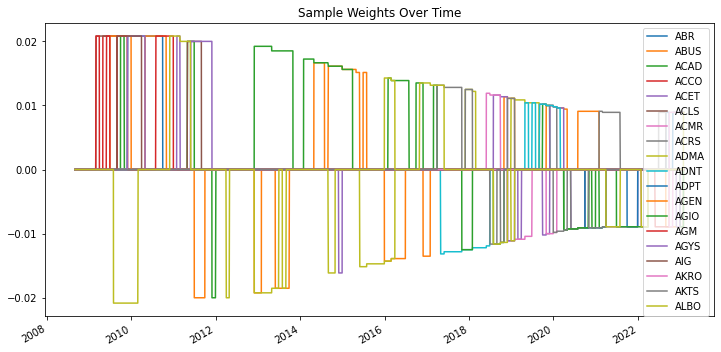

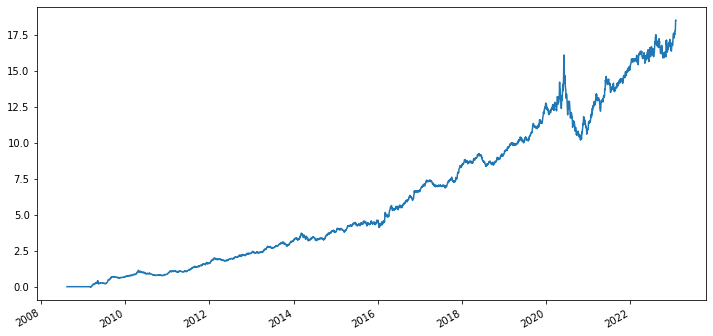

Sharpe Ratio                    1.574102
Drift Adjusted Sharpe Ratio     0.821060
CAGR                            0.227722
Vol                             0.136310
Sortino Ratio                   2.223214
Martin (Ulcer) Ratio            0.001675
Omega Ratio                     1.218286
RR Ratio                        1.335489
Win Rate                        0.534778
Skew                           -0.635959
Kurtosis                       22.686411
Max Drawdown                   -0.345939
VaR - Laplace                  -0.033962
CVaR - Laplace                 -0.042328
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


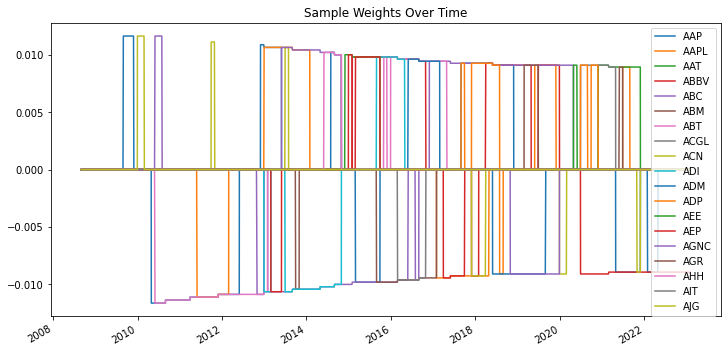

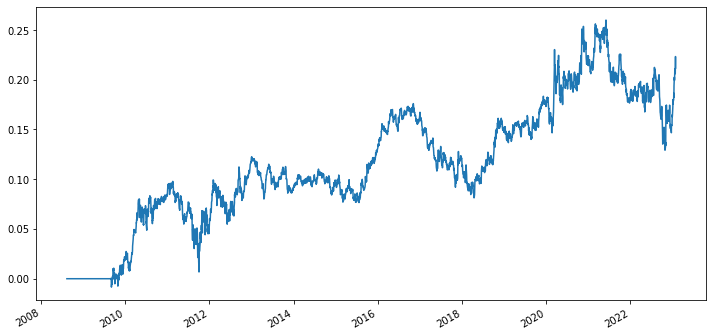

Sharpe Ratio                   0.313888
Drift Adjusted Sharpe Ratio    0.257749
CAGR                           0.013356
Vol                            0.045574
Sortino Ratio                  0.472111
Martin (Ulcer) Ratio           0.000278
Omega Ratio                    0.810539
RR Ratio                       1.058593
Win Rate                       0.503697
Skew                           0.569298
Kurtosis                       8.820931
Max Drawdown                  -0.103655
VaR - Laplace                 -0.010905
CVaR - Laplace                -0.013258
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


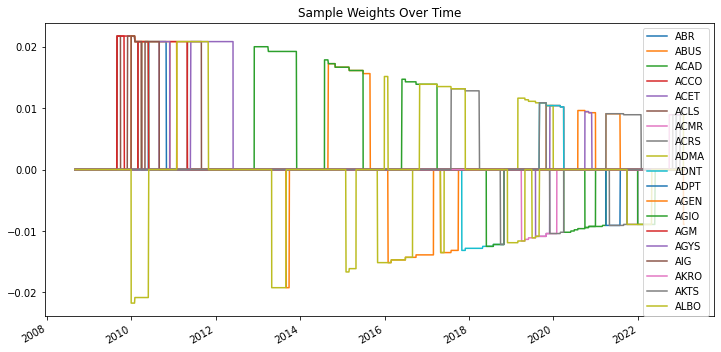

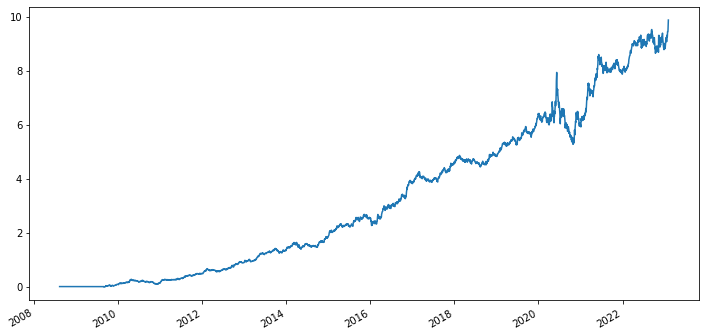

Sharpe Ratio                   1.457567
Drift Adjusted Sharpe Ratio    0.720393
CAGR                           0.179334
Vol                            0.117963
Sortino Ratio                  2.296258
Martin (Ulcer) Ratio           0.001898
Omega Ratio                    1.170116
RR Ratio                       1.297550
Win Rate                       0.526471
Skew                           0.524432
Kurtosis                       7.904582
Max Drawdown                  -0.298228
VaR - Laplace                 -0.028673
CVaR - Laplace                -0.036870
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


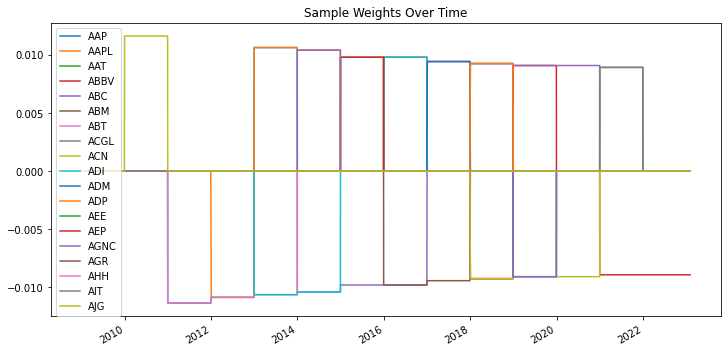

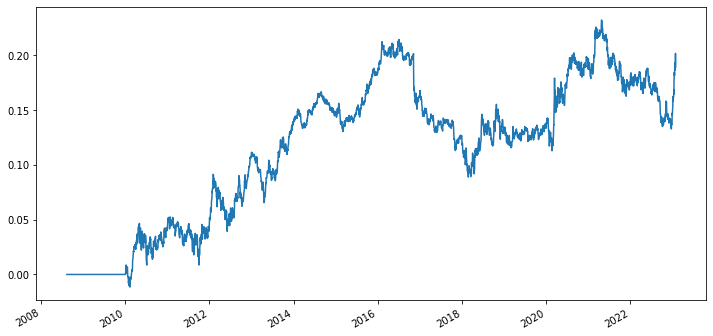

Sharpe Ratio                   0.343974
Drift Adjusted Sharpe Ratio    0.121524
CAGR                           0.012053
Vol                            0.036799
Sortino Ratio                  0.510170
Martin (Ulcer) Ratio           0.000199
Omega Ratio                    0.768576
RR Ratio                       1.063639
Win Rate                       0.500303
Skew                           0.225158
Kurtosis                       5.510465
Max Drawdown                  -0.103317
VaR - Laplace                 -0.008534
CVaR - Laplace                -0.010537
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


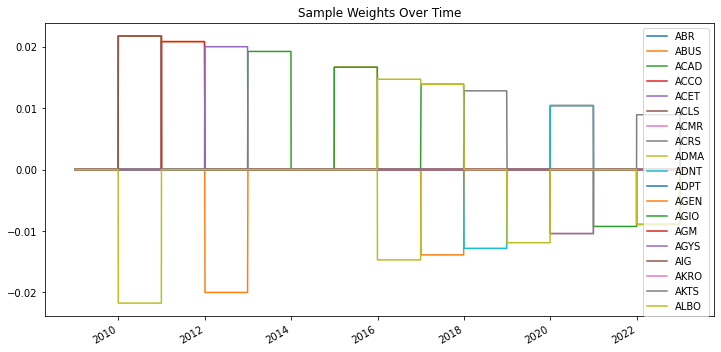

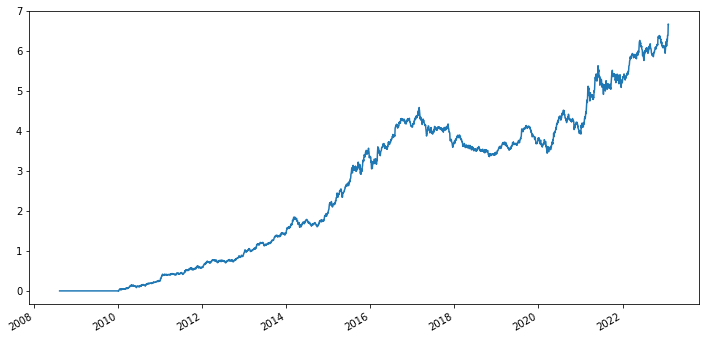

Sharpe Ratio                   1.451328
Drift Adjusted Sharpe Ratio    0.581321
CAGR                           0.151081
Vol                            0.100445
Sortino Ratio                  2.219569
Martin (Ulcer) Ratio           0.001191
Omega Ratio                    1.145447
RR Ratio                       1.290797
Win Rate                       0.532464
Skew                           0.162551
Kurtosis                       4.789813
Max Drawdown                  -0.219902
VaR - Laplace                 -0.024181
CVaR - Laplace                -0.030979
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


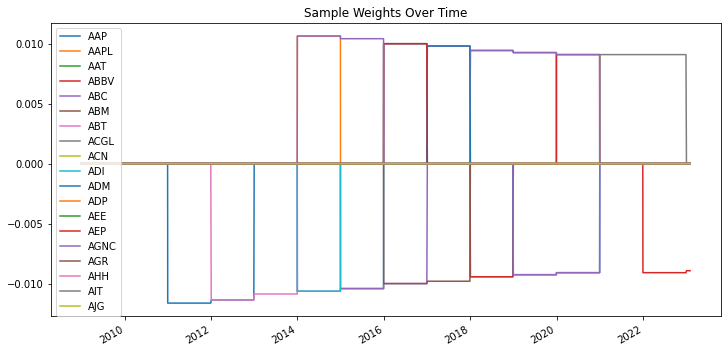

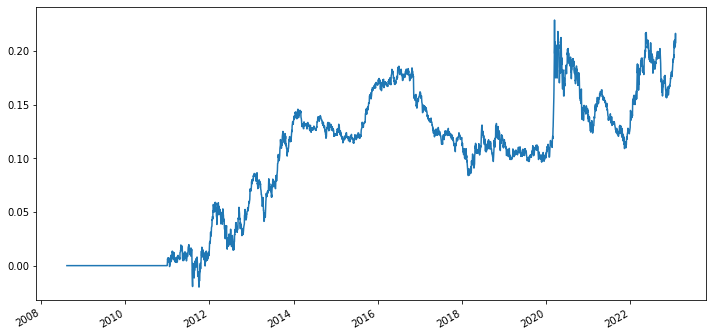

Sharpe Ratio                    0.345572
Drift Adjusted Sharpe Ratio     0.147544
CAGR                            0.013133
Vol                             0.040081
Sortino Ratio                   0.465431
Martin (Ulcer) Ratio            0.000218
Omega Ratio                     0.769312
RR Ratio                        1.071951
Win Rate                        0.510512
Skew                            0.004195
Kurtosis                       14.646636
Max Drawdown                   -0.097442
VaR - Laplace                  -0.009636
CVaR - Laplace                 -0.012099
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


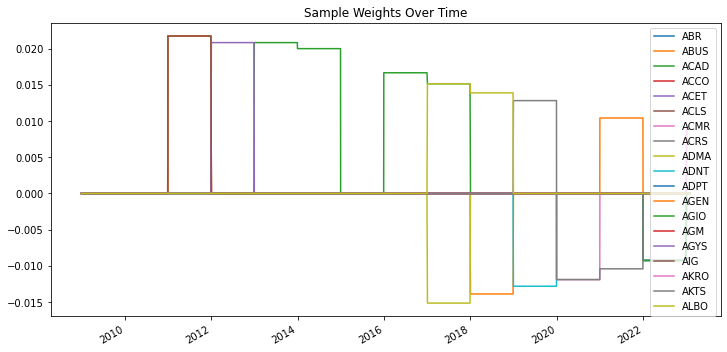

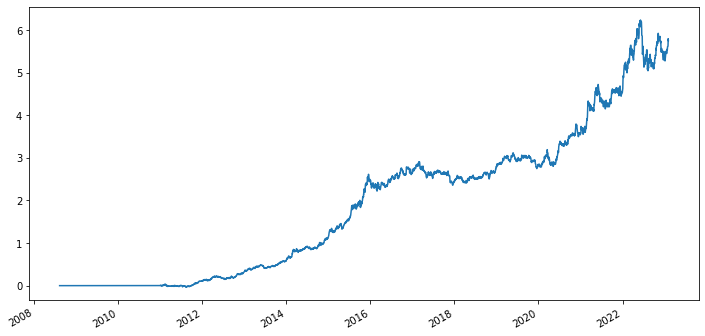

Sharpe Ratio                   1.334133
Drift Adjusted Sharpe Ratio    0.471239
CAGR                           0.141090
Vol                            0.102922
Sortino Ratio                  1.918037
Martin (Ulcer) Ratio           0.001806
Omega Ratio                    1.130548
RR Ratio                       1.277115
Win Rate                       0.535151
Skew                           0.013938
Kurtosis                       5.580249
Max Drawdown                  -0.164468
VaR - Laplace                 -0.024874
CVaR - Laplace                -0.031539
dtype: float64


In [181]:
def momentum(returns: pd.DataFrame):
    rolling_cum_rets = np.exp(np.log(1+returns).rolling(window=int(252)).sum() - 1)
    rolling_cum_rets = (rolling_cum_rets - rolling_cum_rets.mean()) / rolling_cum_rets.std()
    return rolling_cum_rets

factor_1 = factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol') # Short Low Vol (Large Cap) MoM
print(factor_1.performance_summary)
factor_2= factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol') # Short Low Vol (Large Cap) MoM
print(factor_2.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252/2)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    return vol_mom_factor

factor_3 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_3.performance_summary)
factor_4 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_4.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    return vol_mom_factor

factor_5 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_5.performance_summary)
factor_6 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_6.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    return vol_mom_factor

factor_7 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_7.performance_summary)
factor_8 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_8.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252*2)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    return vol_mom_factor

factor_9 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_9.performance_summary)
factor_10 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_10.performance_summary)

Get MVO Portfolio of Factors

Target Vol: 
0.0013898259964094351
Long-Short Ratio: 3.166661727330276
0.4203152387630326
0    -0.008171
1     0.185646
2    -0.012238
3     0.088487
4    -0.173582
5     0.000720
6     0.011521
7     0.032988
8     0.032988
9     0.186344
10    0.075614
dtype: float64


C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Sharpe Ratio                   2.301450
Drift Adjusted Sharpe Ratio    4.894331
CAGR                           0.051826
Vol                            0.022063
Sortino Ratio                  3.658849
Martin (Ulcer) Ratio           0.004985
Omega Ratio                    0.876506
RR Ratio                       1.496250
Win Rate                       0.555587
Skew                           0.212649
Kurtosis                       6.707664
Max Drawdown                  -0.034744
VaR - Laplace                 -0.005420
CVaR - Laplace                -0.006739
dtype: float64

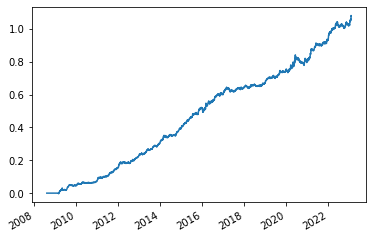

In [182]:
tmp_rets = pd.concat([factor_2.factor_returns, factor_1.factor_returns, factor_3.factor_returns, factor_4.factor_returns, factor_5.factor_returns, factor_6.factor_returns, factor_7.factor_returns, factor_8.factor_returns, factor_8.factor_returns, factor_9.factor_returns, factor_10.factor_returns], axis=1)
mvo_wts = backtest_tools.mvo(tmp_rets, tmp_rets.mean(), constrained=False)
print(mvo_wts)
mvo_rets = (tmp_rets*mvo_wts).sum(1)
backtest_tools.cumulative_returns(mvo_rets).plot()
backtest_tools.performance_summary(mvo_rets)